In [34]:
import pandas as pd
import numpy as np
import seaborn as sns
sns.set(style="ticks")
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split, GridSearchCV,cross_validate,RandomizedSearchCV,cross_val_predict
from sklearn.svm import LinearSVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score,confusion_matrix,precision_score, recall_score,f1_score,precision_recall_curve
from sklearn.preprocessing import OneHotEncoder,LabelEncoder, StandardScaler, MinMaxScaler, scale,PowerTransformer,RobustScaler
from sklearn.svm import SVC
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.ensemble import (RandomForestClassifier, AdaBoostClassifier, 
                              GradientBoostingClassifier, ExtraTreesClassifier,StackingClassifier)
import re
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from pyod.models.knn import KNN

from xgboost import XGBClassifier

from graphviz import Source
from sklearn.tree import export_graphviz

In [2]:
train_df=pd.read_csv("titanic_train.csv",index_col="PassengerId")
test_df=pd.read_csv("titanic_test.csv",index_col="PassengerId")
all_df=pd.concat([train_df,test_df])

In [3]:
#Insert a new columns that divide the Fare into the number of occurencies of the ticket
all_df["ticket occur"]=all_df.groupby(["Ticket"])["Fare"].transform("count")
all_df["Fare"]=all_df["Fare"]/all_df["ticket occur"]
all_df.drop("ticket occur",axis=1,inplace=True)

In [4]:
#Insert a Deck column indicating the deck of the passenger, we take this info from Cabin column
all_df['Cabin'] = all_df['Cabin'].fillna("U0")
all_df['Deck'] = all_df['Cabin'].map(lambda x: re.compile("([a-zA-Z]+)").search(x).group())
#Insert a Family column, indicating the family group size for each passenger, we will do it by adding the "SibSp" and "Parch" columns
all_df["Family"]=all_df["SibSp"]+all_df["Parch"]
#According to an investigation on the internet, both passenger with missing "embarked" boarded in Southhampton
all_df["Embarked"]=all_df["Embarked"].fillna("S")

In [5]:
#Estimate the age of the missing passengers by grouping by Pclass,embarked and sex and taking the median value
all_df["Age"]=all_df["Age"].fillna(all_df.groupby(["Pclass","Embarked","Sex"])["Age"].transform(lambda x:x.median()))
#Estimate the fare of the missing passengers by grouping by Pclass,embarked and sex and taking the median value
all_df["Fare"]=all_df["Fare"].fillna(all_df.groupby(["Pclass","Embarked","Sex"])["Fare"].transform(lambda x:x.median()))

In [6]:
#From the name of the passenger, we extract the title
all_df['Title'] = all_df['Name'].map(lambda x: re.compile("(\w+\.)").search(x).group())

In [7]:
#Replace some titles to decrease the variation of the samples
title_sub=['Mr.', 'Miss.', 'Mrs.', 'Master.', 'Rev.', 'Dr.', 'Mr.', 'Mrs.',
       'Mr.', 'Mr.', 'Miss.', 'Mr.', 'Mrs.', 'Rare', 'Rare',
       'Rare', 'Rare', 'Rare']

dictionary=dict(zip(all_df["Title"].value_counts().index,title_sub))

all_df["Title"]=all_df["Title"].map(dictionary)

In [8]:
#Drop the columns that wont be use: "NAME","SIBSP","PARCH","CABIN"
all_df=all_df.drop(columns=["Name","SibSp","Parch","Cabin","Ticket"])

In [9]:
#Divide the data in X and Y
all_X=all_df.drop(columns="Survived")
all_y=all_df["Survived"]

In [10]:
all_X

,Pclass,Sex,Age,Fare,Embarked,Deck,Family,Title
PassengerId,,,,,,,,
1,3,male,22.00,7.250000,S,U,1,Mr.
2,1,female,38.00,35.641650,C,C,1,Mrs.
3,3,female,26.00,7.925000,S,U,0,Miss.
4,1,female,35.00,26.550000,S,C,1,Mrs.
5,3,male,35.00,8.050000,S,U,0,Mr.
...,...,...,...,...,...,...,...,...
1305,3,male,25.00,8.050000,S,U,0,Mr.
1306,1,female,39.00,36.300000,C,C,0,Mrs.
1307,3,male,38.50,7.250000,S,U,0,Mr.


In [11]:
def divide_cat_num_data(X):
    cat_data=[]
    num_data=[]

    for i,cat in enumerate (X.dtypes):
        if cat==object:
            cat_data.append(X.iloc[:,i])
        else:
            num_data.append(X.iloc[:,i])

    cat_data=pd.DataFrame(cat_data).transpose()
    num_data=pd.DataFrame(num_data).transpose()
    return cat_data,num_data

cat_data,num_data=divide_cat_num_data(all_X)

In [12]:
num_data

,Pclass,Age,Fare,Family
PassengerId,,,,
1,3.0,22.00,7.250000,1.0
2,1.0,38.00,35.641650,1.0
3,3.0,26.00,7.925000,0.0
4,1.0,35.00,26.550000,1.0
5,3.0,35.00,8.050000,0.0
...,...,...,...,...
1305,3.0,25.00,8.050000,0.0
1306,1.0,39.00,36.300000,0.0
1307,3.0,38.50,7.250000,0.0


#Box Cox Transformation of (highly) skewed features

from scipy.stats import skew,boxcox
from scipy.special import boxcox1p

cats=[]

for i in num_data:
    skewness=skew(num_data[i])
    
    if abs(skewness)>0.75:
        num_data[i],lam = boxcox(num_data[i]+1)
        cats.append(i)
        
print("There were {} features skewed that were corrected, these features are:".format(len(cats)))
print(cats)

In [13]:
#scalerx=PowerTransformer()

#num_data_s=pd.DataFrame(scalerx.fit_transform(num_data),columns=num_data.columns)

In [14]:
cat_data_num=pd.get_dummies(cat_data)

In [15]:
cat_data_num

,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S,Deck_A,Deck_B,Deck_C,Deck_D,Deck_E,...,Deck_G,Deck_T,Deck_U,Title_Dr.,Title_Master.,Title_Miss.,Title_Mr.,Title_Mrs.,Title_Rare,Title_Rev.
PassengerId,,,,,,,,,,,,,,,,,,,,,
1,0,1,0,0,1,0,0,0,0,0,...,0,0,1,0,0,0,1,0,0,0
2,1,0,1,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0
3,1,0,0,0,1,0,0,0,0,0,...,0,0,1,0,0,1,0,0,0,0
4,1,0,0,0,1,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0
5,0,1,0,0,1,0,0,0,0,0,...,0,0,1,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1305,0,1,0,0,1,0,0,0,0,0,...,0,0,1,0,0,0,1,0,0,0
1306,1,0,1,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0
1307,0,1,0,0,1,0,0,0,0,0,...,0,0,1,0,0,0,1,0,0,0


In [16]:
all_X_final=pd.merge(cat_data_num,num_data,on=None,how="inner", left_index=True, right_index=True)


In [17]:
all_X_final

,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S,Deck_A,Deck_B,Deck_C,Deck_D,Deck_E,...,Title_Master.,Title_Miss.,Title_Mr.,Title_Mrs.,Title_Rare,Title_Rev.,Pclass,Age,Fare,Family
PassengerId,,,,,,,,,,,,,,,,,,,,,
1,0,1,0,0,1,0,0,0,0,0,...,0,0,1,0,0,0,3.0,22.00,7.250000,1.0
2,1,0,1,0,0,0,0,1,0,0,...,0,0,0,1,0,0,1.0,38.00,35.641650,1.0
3,1,0,0,0,1,0,0,0,0,0,...,0,1,0,0,0,0,3.0,26.00,7.925000,0.0
4,1,0,0,0,1,0,0,1,0,0,...,0,0,0,1,0,0,1.0,35.00,26.550000,1.0
5,0,1,0,0,1,0,0,0,0,0,...,0,0,1,0,0,0,3.0,35.00,8.050000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1305,0,1,0,0,1,0,0,0,0,0,...,0,0,1,0,0,0,3.0,25.00,8.050000,0.0
1306,1,0,1,0,0,0,0,1,0,0,...,0,0,0,1,0,0,1.0,39.00,36.300000,0.0
1307,0,1,0,0,1,0,0,0,0,0,...,0,0,1,0,0,0,3.0,38.50,7.250000,0.0


In [18]:
X_train=all_X_final.iloc[0:train_df.shape[0],:]
X_test=all_X_final.iloc[-test_df.shape[0]:,:]
y_train=all_y.iloc[0:train_df.shape[0]].astype(int)

In [140]:
tree_clf = DecisionTreeClassifier(max_depth=8,min_samples_split=3)
tree_clf.fit(X_train, y_train)

dot_data = export_graphviz(
tree_clf,
#out_file="titanic_tree.dot",
feature_names=X_train.columns,
class_names=["muerto","vivo"],
rounded=True,
filled=True
)

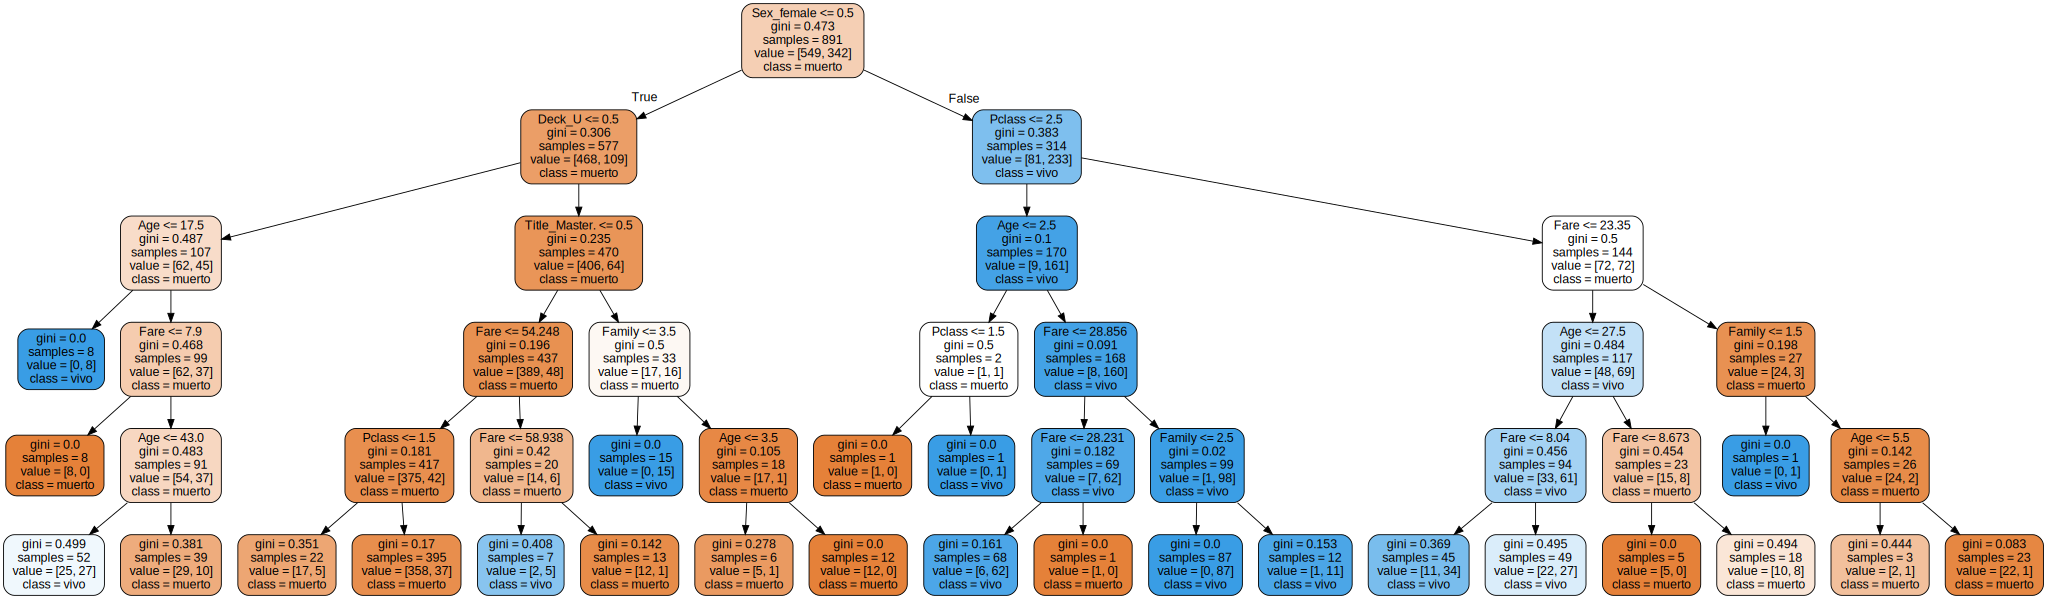

In [141]:
Source.from_file("titanic_tree.dot")

In [142]:
import pydotplus

graph = pydotplus.graph_from_dot_data(dot_data)

In [143]:
graph.write_pdf("titanic.pdf")

True

In [22]:
X_train,X_val,y_train,y_val=train_test_split(X_train,y_train,test_size=0.25)

In [24]:
# Create 4 objects that represent our models
rf = RandomForestClassifier()
et = ExtraTreesClassifier()
ada = AdaBoostClassifier()
gb = GradientBoostingClassifier()
xgb=XGBClassifier()

In [52]:
xgb.fit(X_train,y_train)
y_pred=x.predict(X_val)
accuracy_score(y_val,y_pred)

0.8071748878923767

In [28]:
confusion_matrix(y_val,y_pred)

array([[118,  20],
       [ 23,  62]], dtype=int64)

In [30]:
precision_score(y_val,y_pred)

0.7560975609756098

In [31]:
recall_score(y_val,y_pred)

0.7294117647058823

In [32]:
f1_score(y_val,y_pred)

0.7425149700598803

In [ ]:
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

In [19]:
#lets tune the random forest classificator

params_rfc={"n_estimators":np.arange(20,300,10),
            "criterion":["gini","entropy"],
           "min_samples_split":np.arange(2,6),
           "min_samples_leaf":np.arange(1,5)
           }

rf=RandomizedSearchCV(rf,param_distributions=params_rfc,n_jobs=-1,
                      scoring="accuracy")
rf.fit(X_train,y_train)

print(rf.best_estimator_)
print(rf.best_score_)

RandomForestClassifier(criterion='entropy', min_samples_leaf=3,
                       min_samples_split=4, n_estimators=290)
0.8327600276191074


In [20]:
#lets tune the extra trees classifier
params_et={"n_estimators":np.arange(20,300,10),
            "criterion":["gini","entropy"],
           "min_samples_split":np.arange(2,6),
           "min_samples_leaf":np.arange(1,5)
           }

et=RandomizedSearchCV(et,param_distributions=params_et,n_jobs=-1,
                      scoring="accuracy")
et.fit(X_train,y_train)

print(et.best_estimator_)
print(et.best_score_)

ExtraTreesClassifier(min_samples_leaf=3, min_samples_split=4, n_estimators=250)
0.8260435628648548


In [21]:
#lets tune the ADA classifier

params_ada={"learning_rate":np.arange(0.05,1.05,0.05),
            "n_estimators":np.arange(10,150,10)
           }

ada=RandomizedSearchCV(ada,param_distributions=params_ada,n_jobs=-1,
                      scoring="accuracy")
ada.fit(X_train,y_train)

print(ada.best_estimator_)
print(ada.best_score_)

AdaBoostClassifier(learning_rate=0.4, n_estimators=110)
0.823821480133074


In [22]:
#lets tune the GB classifier
params_gb={"learning_rate":np.arange(0.01,0.5,0.02),
        "n_estimators":np.arange(50,300,20),
           "min_samples_split":np.arange(2,6),
           "min_samples_leaf":np.arange(1,4)
           }


gb=RandomizedSearchCV(gb,param_distributions=params_gb,n_jobs=-1,
                      scoring="accuracy")
gb.fit(X_train,y_train)


print(gb.best_estimator_)
print(gb.best_score_)

GradientBoostingClassifier(learning_rate=0.10999999999999997,
                           min_samples_leaf=3, min_samples_split=5,
                           n_estimators=190)
0.8439771514656957


In [23]:
#Lets tune the XGB classifier

params_xgb={'max_depth':range(3,10,2),
         'min_child_weight':range(1,6,2)
           }


xgb=RandomizedSearchCV(xgb,param_distributions=params_xgb,n_jobs=-1,
                      scoring="accuracy")
xgb.fit(X_train,y_train)


print(xgb.best_estimator_)
print(xgb.best_score_)

XGBClassifier(colsample_bytree=0.8, max_depth=7, min_child_weight=3,
              n_estimators=140, nthread=4, subsample=0.8)
0.8451321323206328


In [24]:
rf=rf.best_estimator_
et=et.best_estimator_
ada=ada.best_estimator_
gb=gb.best_estimator_
xgb=xgb.best_estimator_

In [26]:
rf.set_params(warm_start=True,oob_score=True,n_estimators=500)

rf.fit(X_train,y_train)
print(rf.score(X_train,y_train))
print(rf.oob_score_)

0.8843995510662177
0.8316498316498316


In [28]:
et.set_params(bootstrap=True,warm_start=True,oob_score=True,n_estimators=500)

et.fit(X_train,y_train)
print(et.score(X_train,y_train))
print(et.oob_score_)

0.8597081930415263
0.8451178451178452


In [31]:
ada.set_params(n_estimators=10000)

et.fit(X_train,y_train)
print(et.score(X_train,y_train))
print(et.oob_score_)

C:\Users\matia\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:368: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  warn("Warm-start fitting without increasing n_estimators does not "


0.8597081930415263
0.8451178451178452


In [32]:
gb.set_params(warm_start=True,n_estimators=500,subsample=0.8)

gb.fit(X_train,y_train)
print(gb.score(X_train,y_train))
print(gb.oob_improvement_)

0.9696969696969697
[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00

In [34]:
xgb.set_params(warm_start=True,n_estimators=1000)

xgb.fit(X_train,y_train)
print(xgb.score(X_train,y_train))

0.9719416386083053


In [35]:
xgb.set_params(warm_start=True,n_estimators=10000)

xgb.fit(X_train,y_train)
print(xgb.score(X_train,y_train))

0.9831649831649831


In [36]:
estimators=[rf,et,ada,gb,xgb]

In [37]:
for i in estimators:
    scores=cross_validate(i,X_train,y_train,scoring="accuracy")
    print("The accuracy of {} is {}".format(i,scores["test_score"].mean()))

The accuracy of RandomForestClassifier(criterion='entropy', min_samples_leaf=3,
                       min_samples_split=4, n_estimators=500, oob_score=True,
                       warm_start=True) is 0.8316489862532169
The accuracy of ExtraTreesClassifier(bootstrap=True, min_samples_leaf=3, min_samples_split=4,
                     n_estimators=500, oob_score=True, warm_start=True) is 0.8193082669010107
The accuracy of AdaBoostClassifier(learning_rate=0.4, n_estimators=10000) is 0.8114619295712762
The accuracy of GradientBoostingClassifier(learning_rate=0.10999999999999997,
                           min_samples_leaf=3, min_samples_split=5,
                           n_estimators=500, subsample=0.8, warm_start=True) is 0.8305379448873266
The accuracy of XGBClassifier(colsample_bytree=0.8, max_depth=7, min_child_weight=3,
              n_estimators=10000, nthread=4, subsample=0.8, warm_start=True) is 0.814801330738811


In [38]:
stack=StackingClassifier(estimators=[("rfc",rf),
                                    ("etc",et),
                                    ("ada",ada),
                                    ("gbc",gb),
                                    ("xgb",xgb)])

In [39]:
stack.fit(X_train,y_train)

StackingClassifier(estimators=[('rfc',
                                RandomForestClassifier(criterion='entropy',
                                                       min_samples_leaf=3,
                                                       min_samples_split=4,
                                                       n_estimators=500,
                                                       oob_score=True,
                                                       warm_start=True)),
                               ('etc',
                                ExtraTreesClassifier(bootstrap=True,
                                                     min_samples_leaf=3,
                                                     min_samples_split=4,
                                                     n_estimators=500,
                                                     oob_score=True,
                                                     warm_start=True)),
                               ('ada',
          

In [40]:
y_pred=stack.predict(X_test)

In [41]:
scores=cross_validate(stack,X_train,y_train,scoring="accuracy")

In [42]:
scores["test_score"].mean()

0.8417613458037788

In [43]:
prediction=pd.DataFrame()
prediction['PassengerId'] = X_test.index.values
prediction['Survived'] = y_pred
prediction.to_csv('prediction.csv',index=False)